# Radioflux Data

https://lasp.colorado.edu/lisird/data/noaa_radio_flux/

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import pymc3 as pm
import arviz as az
import theano.tensor as tt

In [2]:
df = pd.read_csv ('../Data/noaa_radio_flux.csv', delimiter=',')
df.head()

,time (yyyyMMdd),f107_adjusted (solar flux unit (SFU)),f107_observed (solar flux unit (SFU))
0,19470214,253.9,260.4
1,19470217,228.5,234.2
2,19470219,178.8,183.1
3,19470220,163.7,167.4
4,19470224,164.1,167.7


In [3]:
time = np.array(pd.to_datetime(df['time (yyyyMMdd)'], format='%Y%m%d'))
flux_adj = df['f107_adjusted (solar flux unit (SFU))']
flux_obs = df['f107_observed (solar flux unit (SFU))']

In [4]:
from scipy.signal import savgol_filter

In [5]:
window_length = int(0.6*365) + 2 # the number of coefficients --> must be odd
poly_order = [1, 2, 4] # order of the polynomial used to fit the samples
color = ['deeppink', 'tab:blue', 'tab:green', 'lightgrey']
zorder = [99, 98, 97]
size = len(poly_order)
smoothed = [savgol_filter(flux_adj, window_length, poly_order[i]) for i in range(size)]

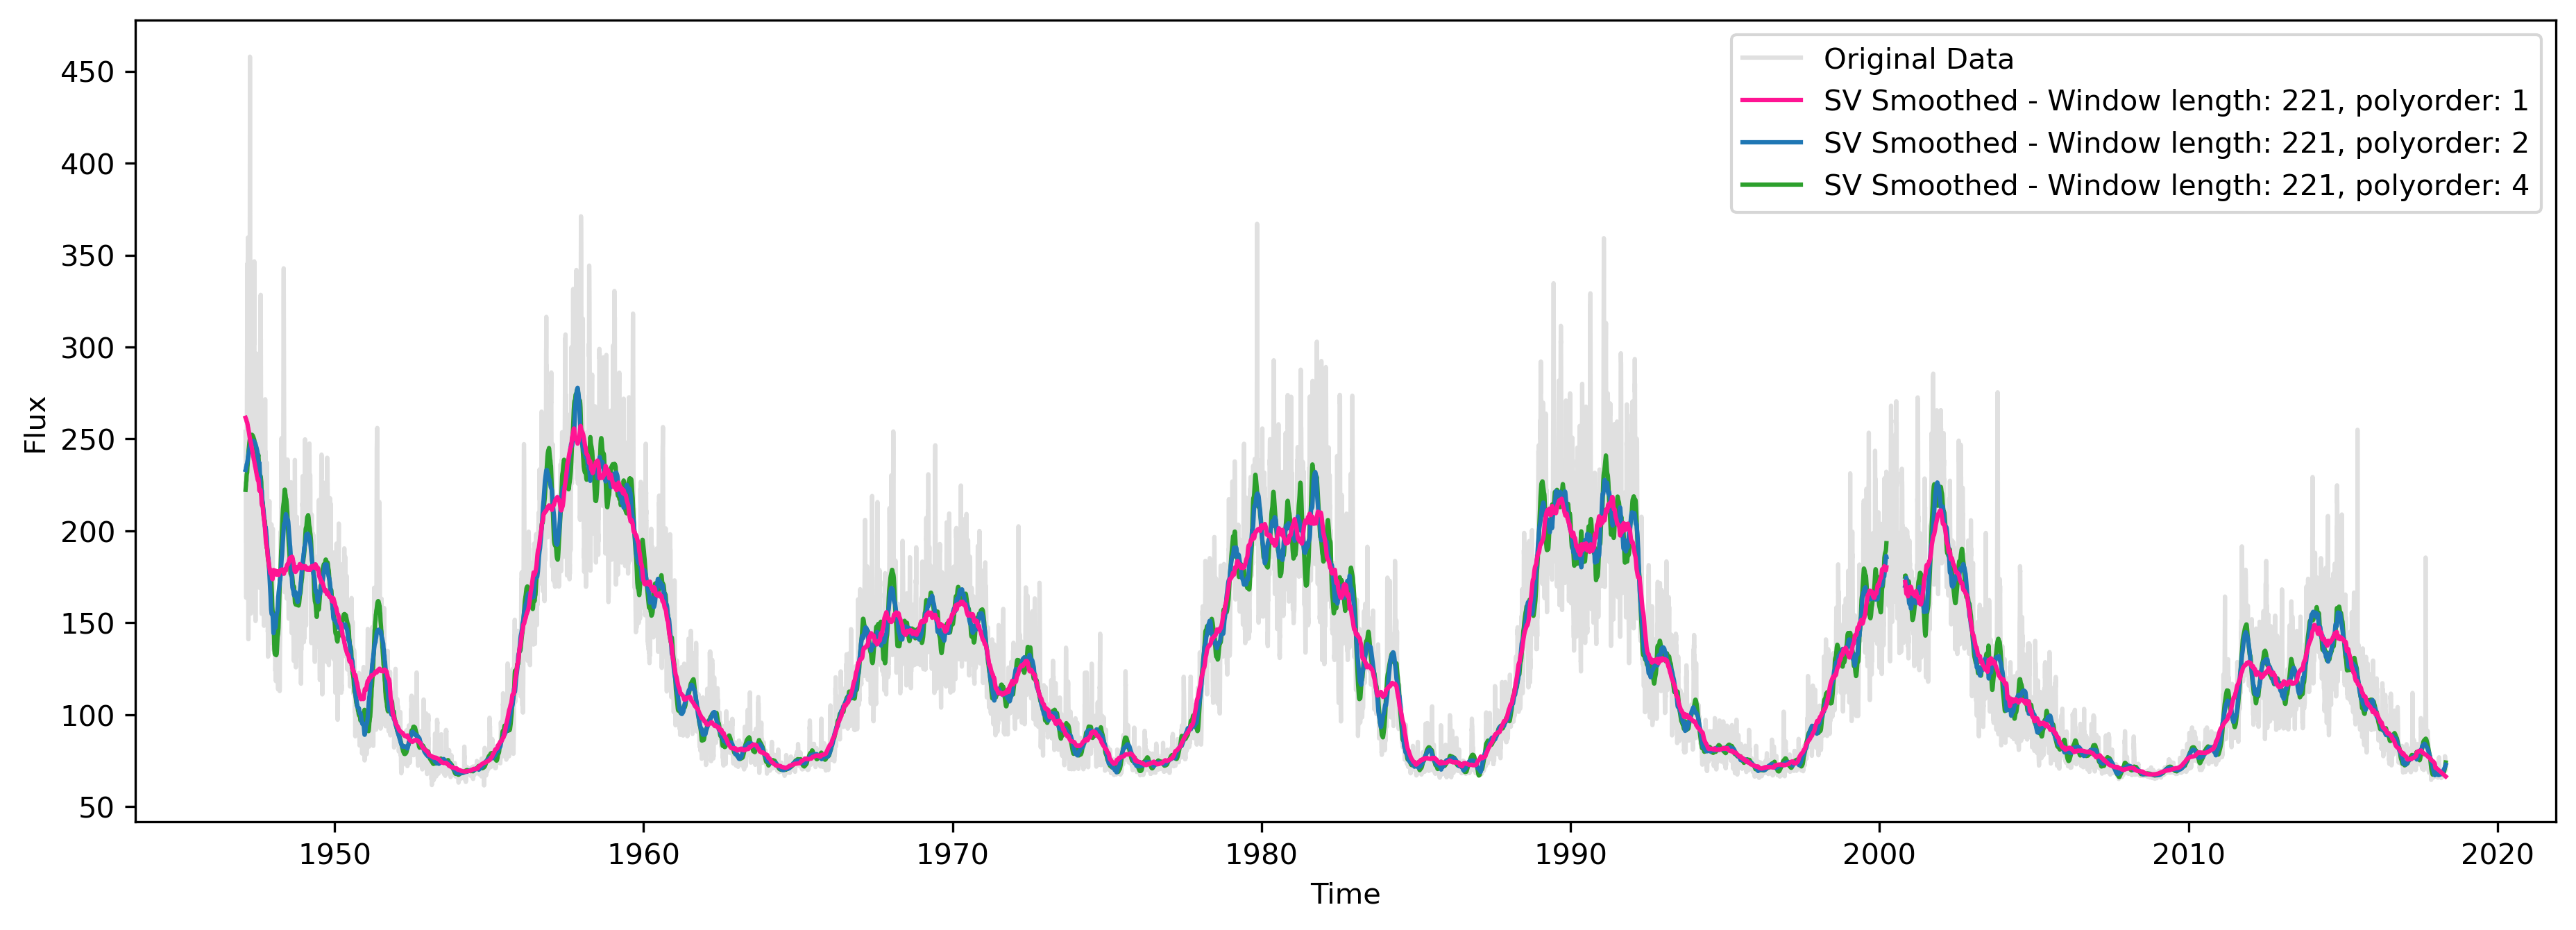

In [6]:
alpha=0.7 # determines opacity
 
fig, ax = plt.subplots(dpi=300, figsize=[15, 5])
ax.plot(time, flux_adj, alpha=alpha, label='Original Data', color=color[-1])
for i in range(size):
    ax.plot(time, smoothed[i],
        label=f'SV Smoothed - Window length: {window_length}, polyorder: {poly_order[i]}', 
       zorder=zorder[i], color = color[i])
ax.set_xlabel('Time')
ax.set_ylabel('Flux')
ax.legend();
#fig.savefig('svg_plot.png');

In [7]:
X = (time).reshape(-1,1)
y = smoothed[0]

In [8]:
training_values = X[::50], y[::50]
training_data = training_values[0], np.log(training_values[1])

X_train = training_data[0]
y_train = training_data[1]

print(training_data[0].shape)

(508, 1)


In [10]:
''' NEED TO CONVERT DATETIME TO DATE IN FRACTION OF YEAR '''
X_train

array([['1947-02-14T00:00:00.000000000'],
       ['1947-04-24T00:00:00.000000000'],
       ['1947-06-24T00:00:00.000000000'],
       ['1947-08-22T00:00:00.000000000'],
       ['1947-10-22T00:00:00.000000000'],
       ['1947-12-19T00:00:00.000000000'],
       ['1948-02-17T00:00:00.000000000'],
       ['1948-04-14T00:00:00.000000000'],
       ['1948-06-10T00:00:00.000000000'],
       ['1948-08-05T00:00:00.000000000'],
       ['1948-10-03T00:00:00.000000000'],
       ['1948-11-27T00:00:00.000000000'],
       ['1949-01-25T00:00:00.000000000'],
       ['1949-03-22T00:00:00.000000000'],
       ['1949-05-20T00:00:00.000000000'],
       ['1949-07-15T00:00:00.000000000'],
       ['1949-09-07T00:00:00.000000000'],
       ['1949-11-01T00:00:00.000000000'],
       ['1950-01-01T00:00:00.000000000'],
       ['1950-03-04T00:00:00.000000000'],
       ['1950-05-10T00:00:00.000000000'],
       ['1950-07-25T00:00:00.000000000'],
       ['1950-09-29T00:00:00.000000000'],
       ['1950-12-11T00:00:00.00000

In [9]:
# Define Sinusoidal Mean Function
class SinusoidalMean(pm.gp.mean.Mean):
    def __init__(self, amplitude):
        super().__init__()
        self.amplitude = amplitude
    
    def __call__(self, x):
        return tt.log(self.amplitude * tt.sin(x[:, 0] * np.pi / period + phase)**2 + offset)

# Define the Gaussian Process
with pm.Model() as model:
    ''' Change the priors '''
    # Define the phase of the sinusoidal mean
    phase = pm.Beta('phase', 2, 2) 
    
    # Define the amplitude of the sinusoidal mean
    amplitude = pm.Gamma('amplitude', 7.5, 0.5) 
     
    # Define the offset of the sinusoidal mean
    offset = pm.Gamma('offset', 7.5, 1) 
    
    # Define the `Period' as a normal distribtion with mean = 11 years
    period = pm.Normal('period', 11, 2)
    
    # Define the `length scale 1' of the periodic kernel as a normal distribution with mean = 1 year
    length_scale1 = pm.Gamma('Length Scale 1', 7.5, 1)  
    
    # Define the `length_scale 2' of the squared-exponential kernel as a normal distribution with mean = 9 years
    length_scale2 = pm.Gamma('Length Scale 2', 7.5, 1)
    
    # Define the `Standard deviation' as a beta function
    sigma = pm.Gamma('$\sigma$', 7.5, 0.5)
    
    # Define the periodic kernel
    cov_periodic = pm.gp.cov.Periodic(1, period=period, ls=length_scale1)
    
    # Define the squared-exponential kernel
    cov_SE = pm.gp.cov.ExpQuad(1, ls=length_scale2)
    
    # Define the quasi-periodic kernel
    cov_qp = cov_SE * cov_periodic 
    
    sinusoidal_mean = SinusoidalMean(amplitude)
    
    gp = pm.gp.Marginal(cov_func=cov_qp, mean_func=sinusoidal_mean)  # implementation of the sum of a GP prior and noise

    y_ = gp.marginal_likelihood("y", X=X_train, y=y_train, noise=sigma)

    tr = pm.sample(return_inferencedata=True) # finds local maximimum 'a posteriori point' given a model

UFuncTypeError: ufunc 'multiply' cannot use operands with types dtype('<M8[ns]') and dtype('float64')

In [ ]:
az.plot_posterior(tr, linewidth=2, c='tab:blue', figsize=(21,3.2), textsize=12);